In [1]:
# import data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import linear_explanation
import torch
import math

In [5]:
# Dictionary of model configurations
models = {
    'vit_b_16_11_mlp1': {
        'exp_address': 'results/ours/LE_siglip/vit_b_16_imagenet_encoder.layers.encoder_layer_11.mlp[1].csv',
        'dataset_name': "imagenet_val",
        'target_name': "vit_b_16_imagenet",
        'target_layer': "encoder.layers.encoder_layer_11.mlp[1]",
        'pool_mode': "first",
    },
    'vit_b_16_10_mlp1': {
        'exp_address': 'results/ours/LE_siglip/vit_b_16_imagenet_encoder.layers.encoder_layer_10.mlp[1].csv',
        'dataset_name': "imagenet_val",
        'target_name': "vit_b_16_imagenet",
        'target_layer': "encoder.layers.encoder_layer_10.mlp[1]",
        'pool_mode': "first",
    },
    'vit_l_32_23_mlp1': {
        'exp_address': 'results/ours/LE_siglip/vit_l_32_imagenet_encoder.layers.encoder_layer_23.mlp[1].csv',
        'dataset_name': "imagenet_val",
        'target_name': "vit_l_32_imagenet",
        'target_layer': "encoder.layers.encoder_layer_23.mlp[1]",
        'pool_mode': "first"
    },
    'resnet50_4': {
        'exp_address': 'results/ours/LE_siglip/resnet50_imagenet_layer4.csv',
        'dataset_name': "imagenet_val",
        'target_name': "resnet50_imagenet",
        'target_layer': "layer4",
        'pool_mode': "avg"
    },
    'imagenet_lf_cbm':{
        'exp_address': 'results/le_siglip_imagenet_lf_cbm_proj_layer.csv',
        'dataset_name': "imagenet_val",
        'target_name': "imagenet_lf_cbm",
        'target_layer': "proj_layer",
        'pool_mode': "avg"
    }
}

# Dictionary to store the processed dataframes
dfs = {}

# load explanations
for model_name, model_info in models.items():
    # Read the CSV file
    df = pd.read_csv(model_info['exp_address'])
    
    if 'layer' in df.columns:
        # Convert the 'layer' column to string type to preserve leading zeros
        df['layer'] = df['layer'].astype(str)
        # Remove the 'layer' column and set 'unit' as the index
        df = df.drop('layer', axis=1).set_index('unit')
    else:
        # Set 'unit' as the index
        df = df.set_index('unit')
    
    # Insert 'sim correlation' as the second column (index 1)
    if 'sim correlation' in df.columns:
        columns = df.columns.tolist()
        columns.remove('sim correlation')
        columns.insert(1, 'sim correlation')
        df = df[columns]
    
    # Store the processed dataframe in the dictionary
    dfs[model_name] = df


loading unexpected model(for cbm)resnet50


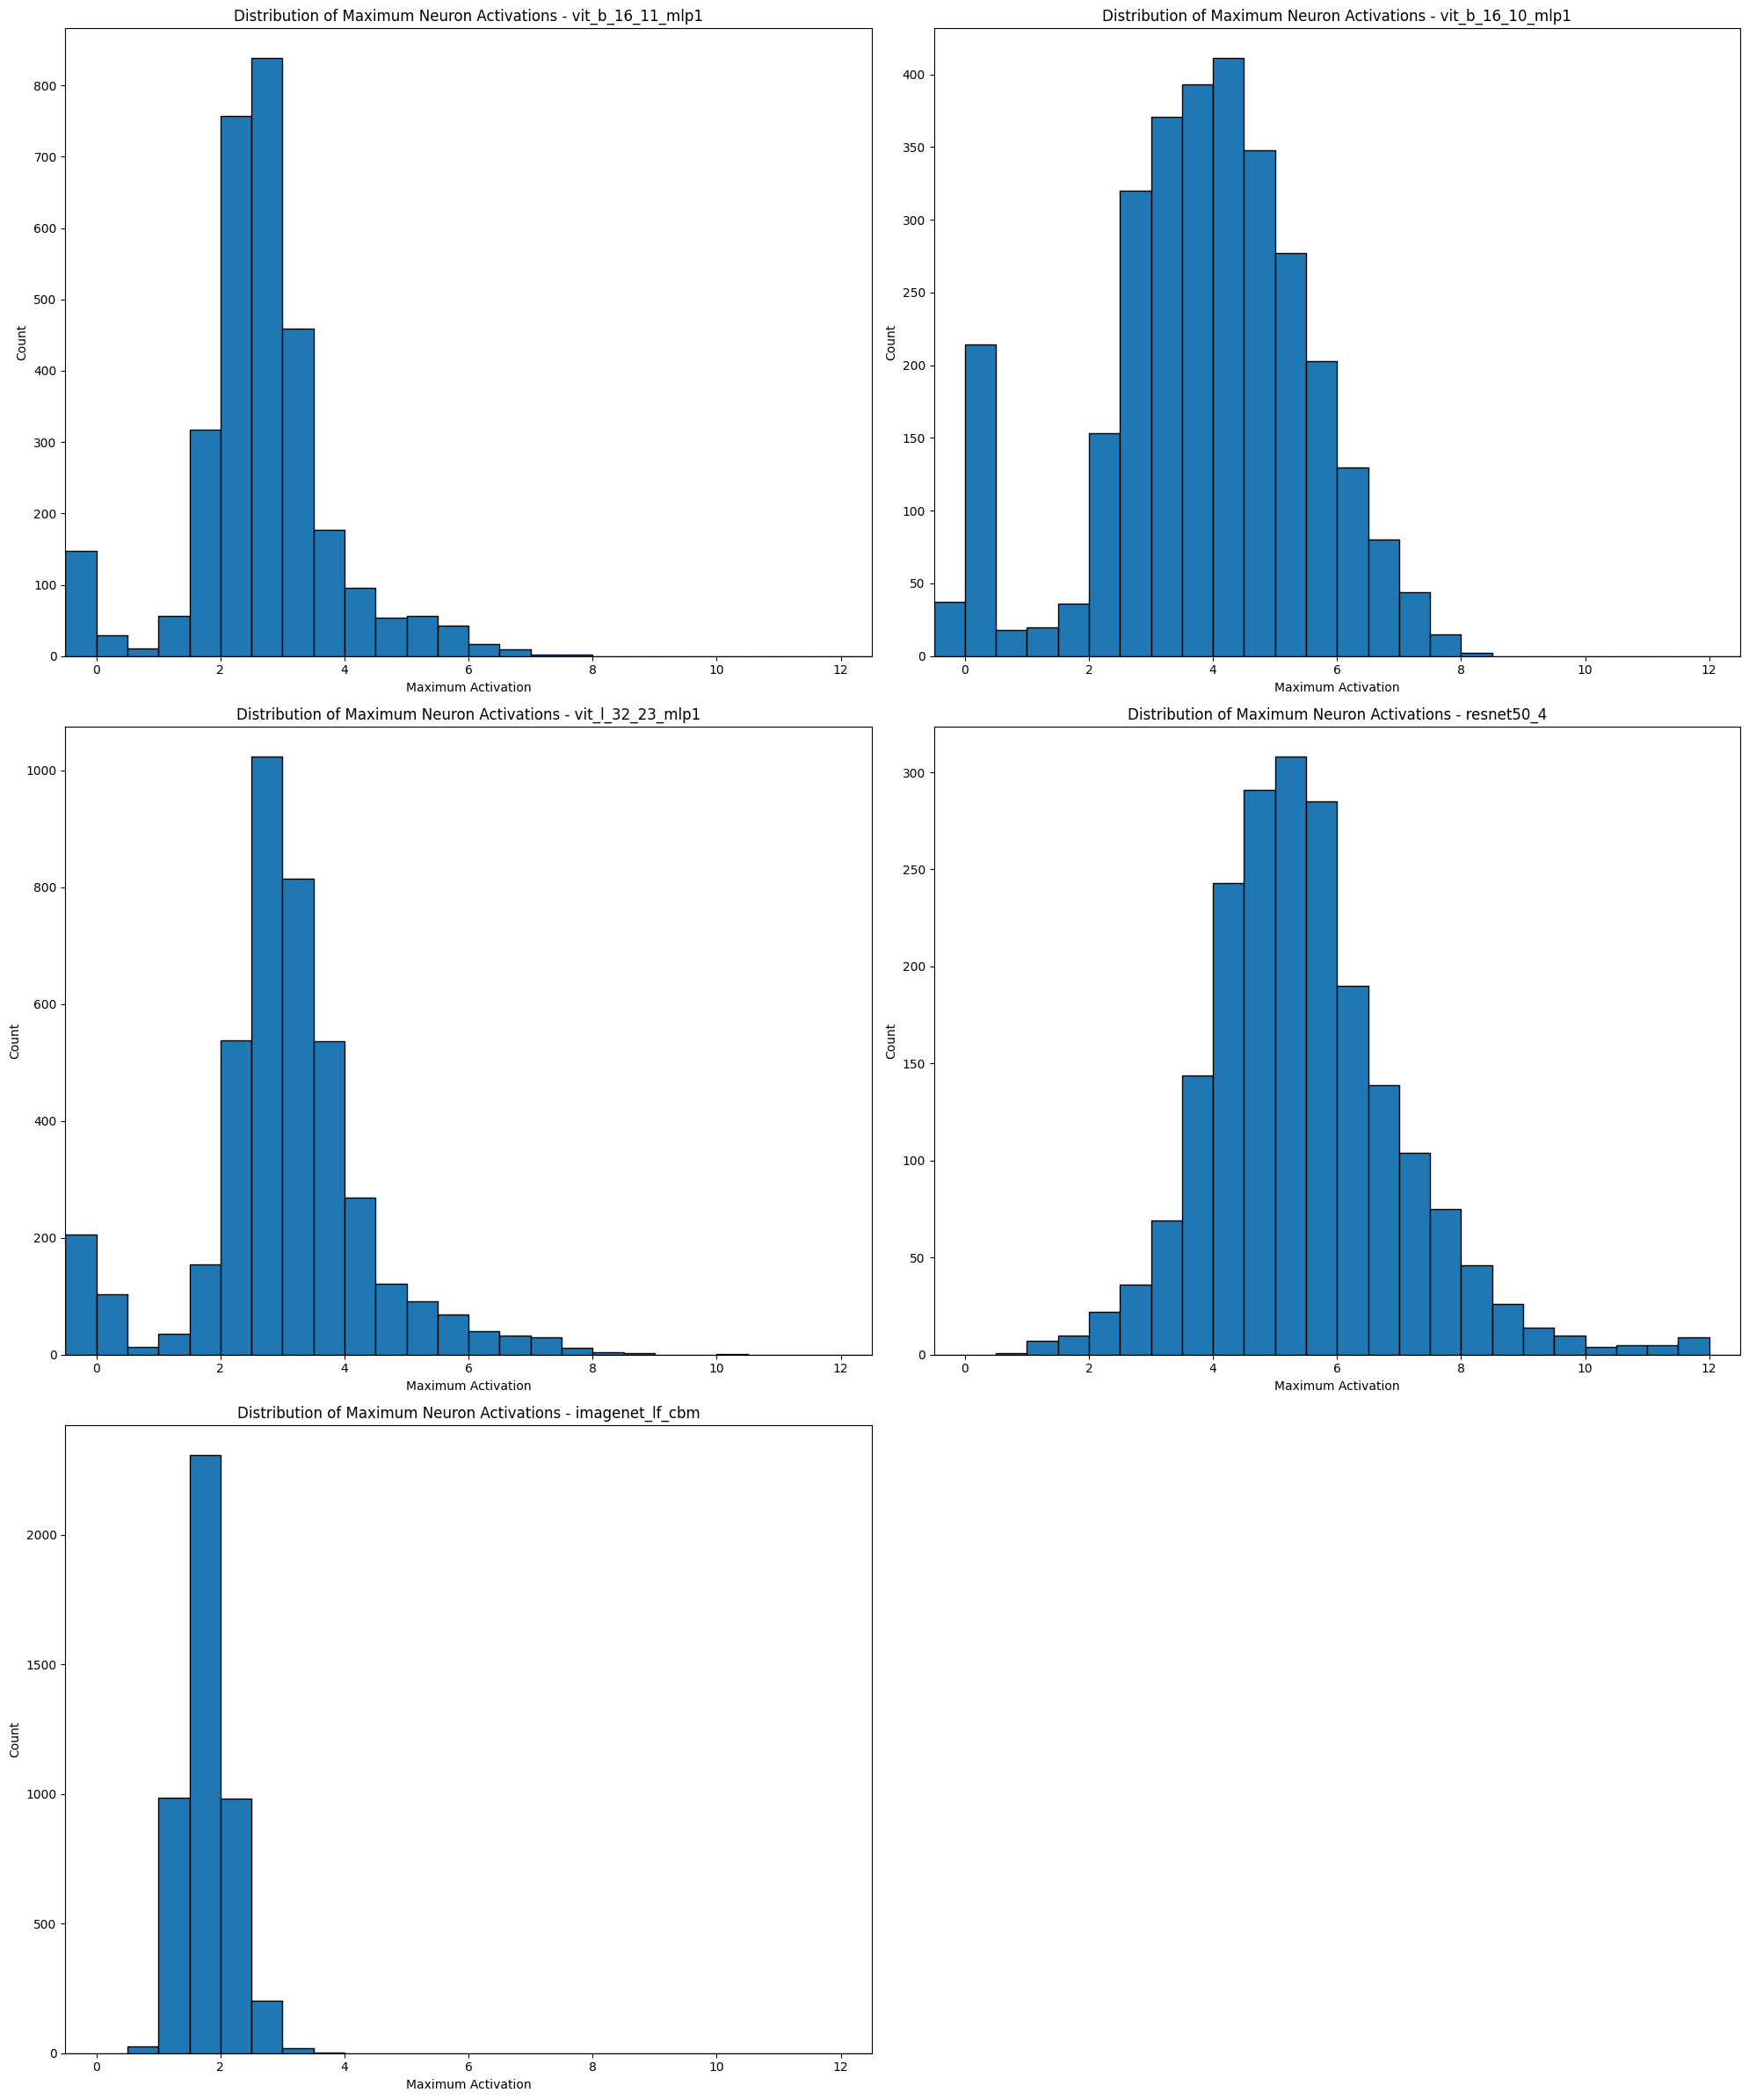

In [6]:
activations_dir = "saved_activations"
batch_size = 128
device = "cuda"

# Set up the bins
bins = np.arange(-0.5, 13, 0.5)

# Calculate the number of rows needed
num_models = len(models)
num_rows = math.ceil(num_models / 2)

# Set up the subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 8 * num_rows))
axs = axs.ravel()  # Flatten the array to make indexing easier

for i, (model_name, model_info) in enumerate(models.items()):
    target_activations = linear_explanation.get_target_acts(target_name=model_info['target_name'], 
                                                            dataset_name=model_info['dataset_name'],
                                                            target_layer=model_info['target_layer'], 
                                                            save_dir=activations_dir,
                                                            batch_size=batch_size, 
                                                            device=device, 
                                                            pool_mode=model_info['pool_mode'])
    
    # Compute max activations on GPU
    neurons_maxs = torch.max(target_activations, dim=0)[0]
    
    # Move result back to CPU for plotting
    neurons_maxs = neurons_maxs.cpu().numpy()
    
    # Plot the histogram
    axs[i].hist(neurons_maxs, bins=bins, edgecolor='black')
    axs[i].set_title(f'Distribution of Maximum Neuron Activations - {model_name}')
    axs[i].set_xlabel('Maximum Activation')
    axs[i].set_ylabel('Count')
    axs[i].set_xlim(-0.5, 12.5)  # Set x-axis limits to match bin range

# Remove any unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## check activations

## concepts explanations

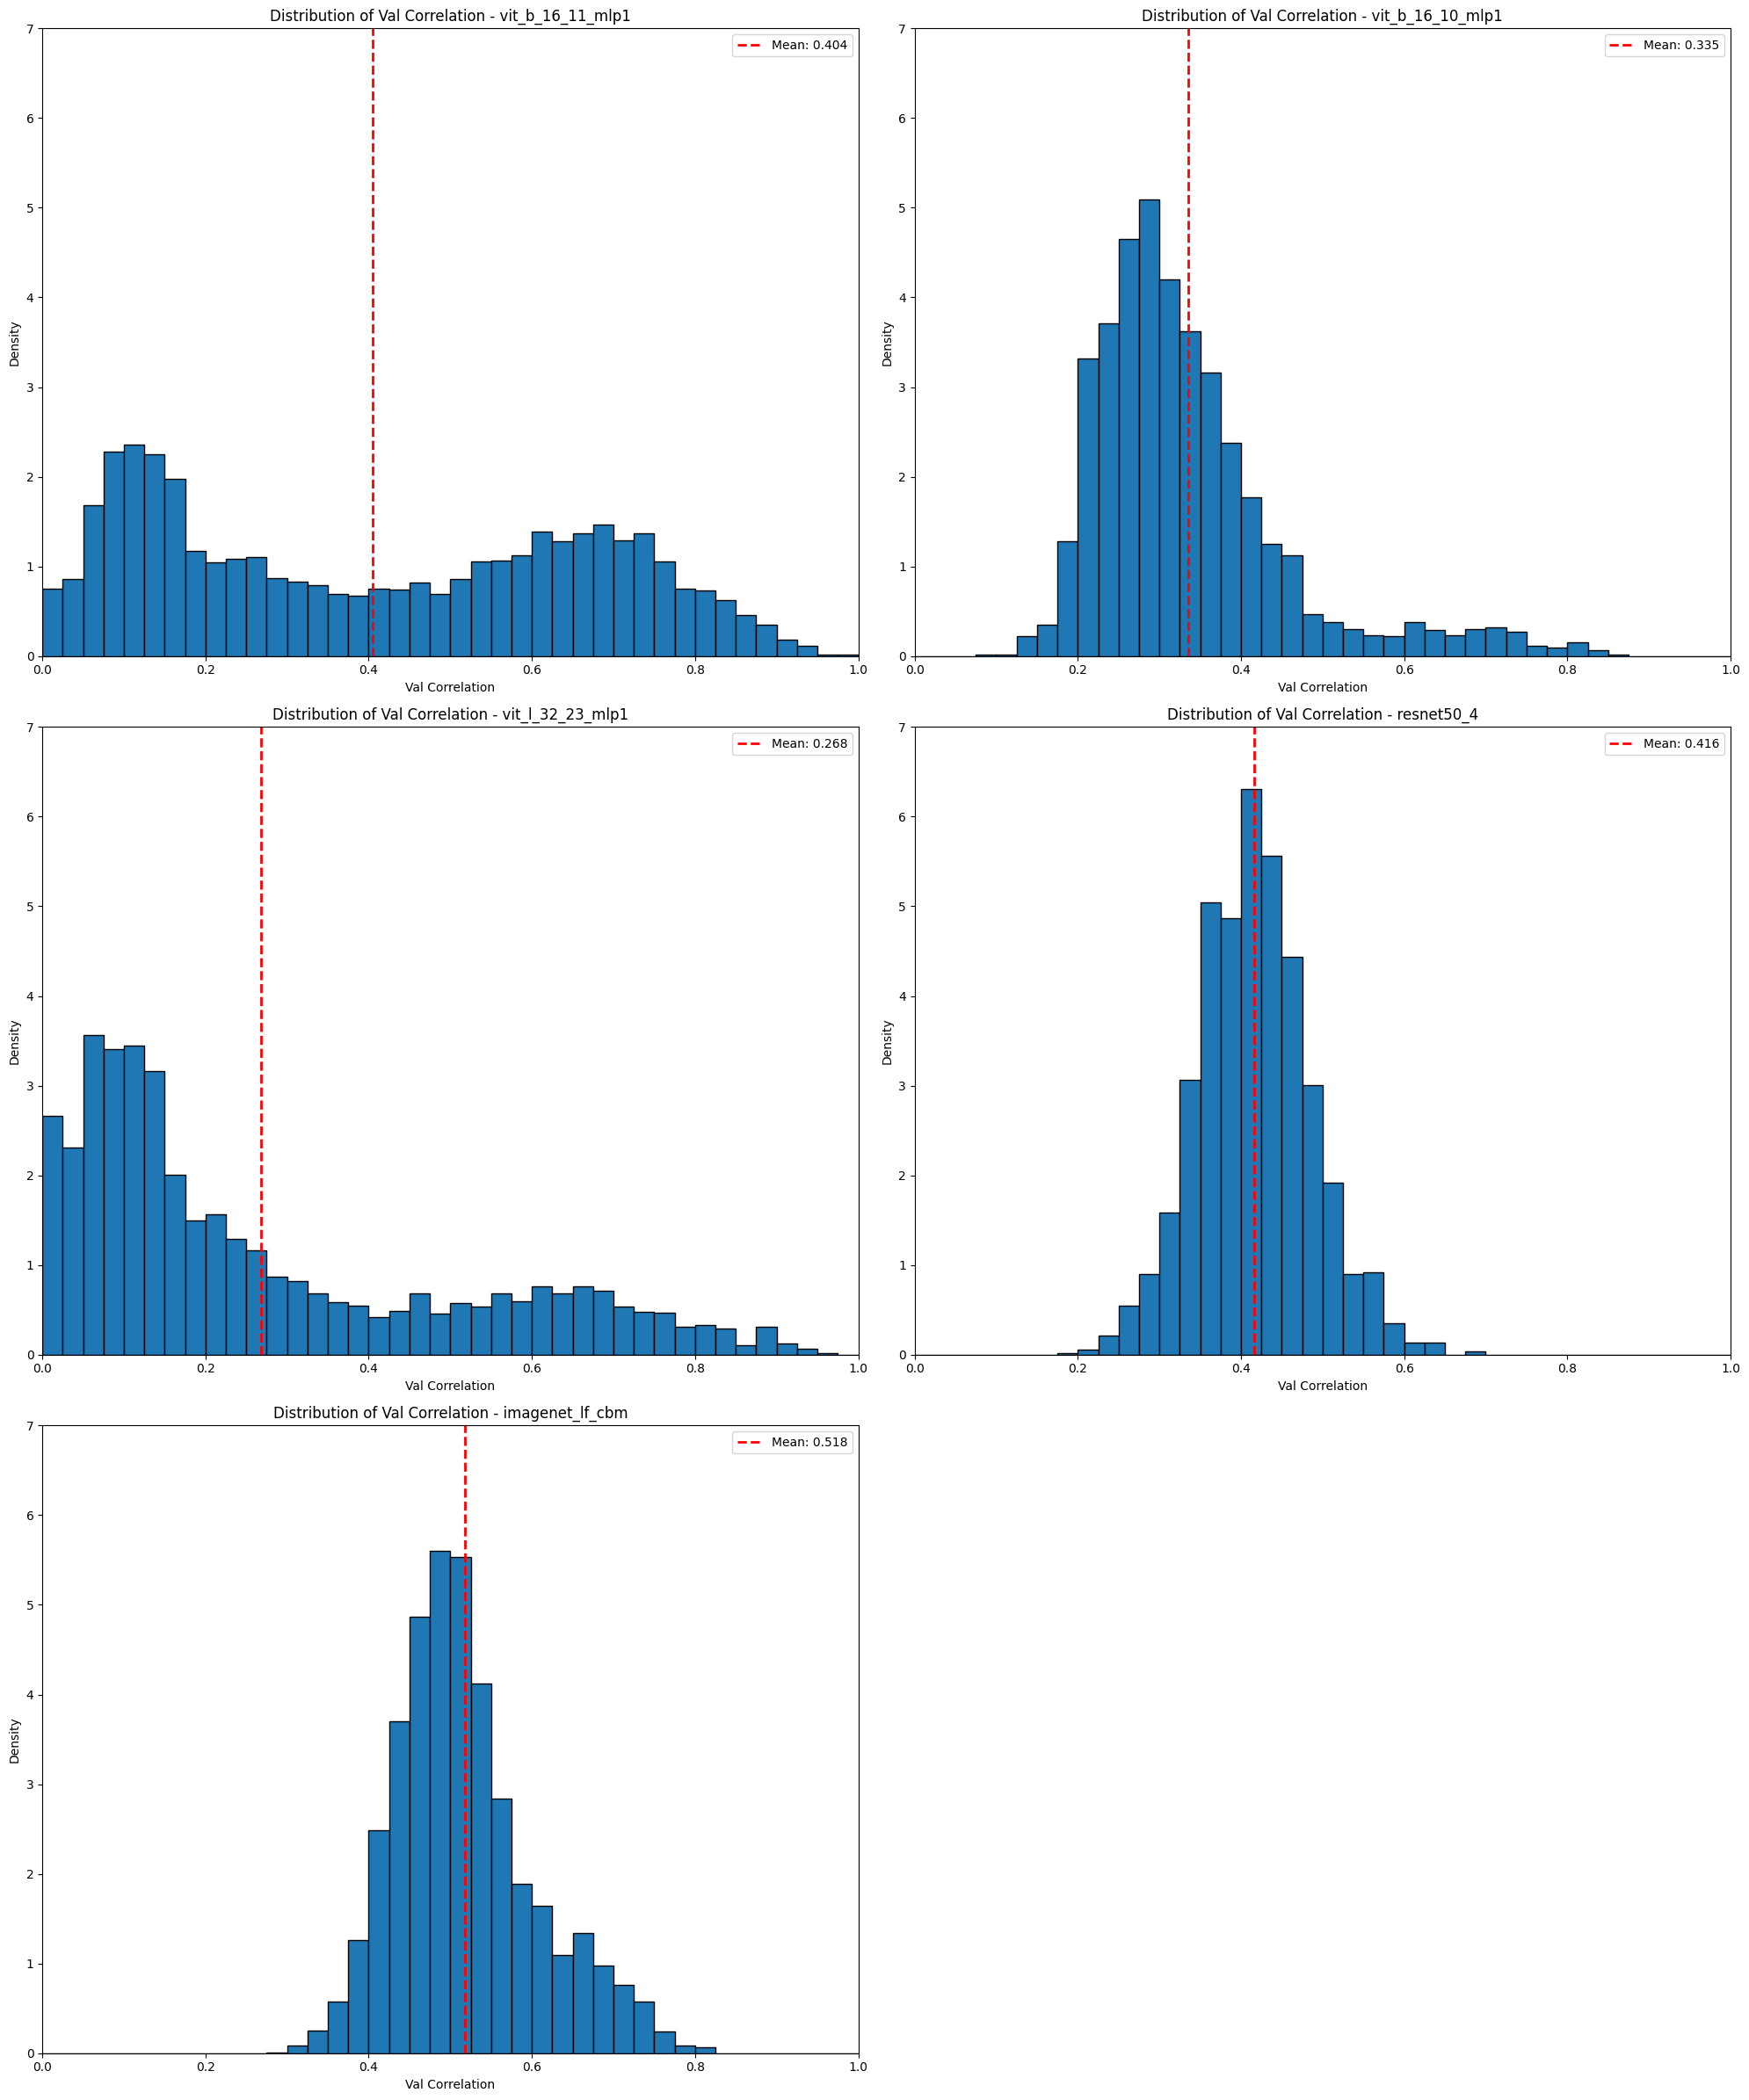

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import math

bins = np.linspace(0, 1, 41)  # 40 bins from 0 to 1

# Calculate the number of rows needed (always using 2 columns)
num_models = len(dfs)
num_rows = math.ceil(num_models / 2)

# Set up the subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 8 * num_rows))
axs = axs.ravel()  # Flatten the array to make indexing easier

for i, (model_name, df) in enumerate(dfs.items()):
    # Extract the 'val correlation' column
    val_correlation = df['val correlation'].values
    
    # Calculate the mean
    mean_val_correlation = np.mean(val_correlation)
    
    # Plot the histogram
    axs[i].hist(val_correlation, bins=bins, edgecolor='black', density=True)
    
    # Add a vertical line for the mean
    axs[i].axvline(mean_val_correlation, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val_correlation:.3f}')
    
    axs[i].set_title(f'Distribution of Val Correlation - {model_name}')
    axs[i].set_xlabel('Val Correlation')
    axs[i].set_ylabel('Density')
    axs[i].set_ylim(0, 7)
    axs[i].set_xlim(0, 1)  # Set x-axis limits from 0 to 1
    axs[i].legend()  # Add legend to show mean value

# Remove any unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

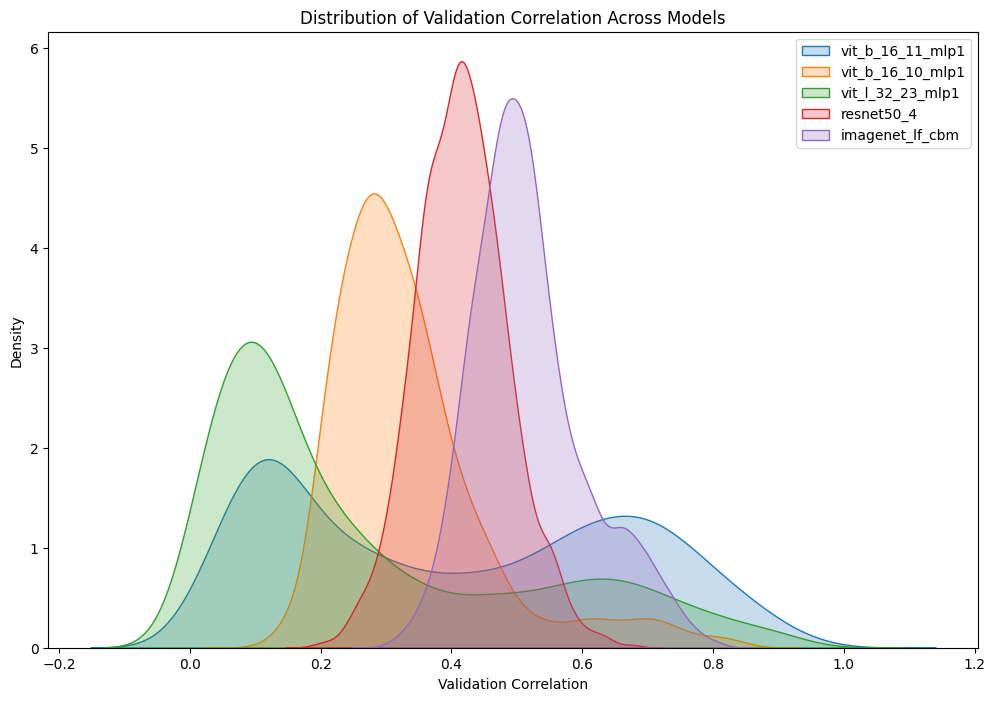

In [8]:
# Set up the plot
plt.figure(figsize=(12, 8))

# Plot the distribution for each model
for model_name, df in dfs.items():
    # Extract 'val correlation' and plot its distribution
    sns.kdeplot(df['val correlation'], label=model_name, fill=True)

# Customize the plot
plt.xlabel('Validation Correlation')
plt.ylabel('Density')
plt.title('Distribution of Validation Correlation Across Models')
plt.legend()

# Show the plot
plt.show()

In [10]:
# # Set up the plot
# plt.figure(figsize=(12, 8))

# # Plot the distribution for each model
# for model_name, df in dfs.items():
#     # Extract 'val correlation' and plot its distribution
#     sns.kdeplot(df['sim correlation'], label=model_name, fill=True)

# # Customize the plot
# plt.xlabel('Simulation Correlation')
# plt.ylabel('Density')
# plt.title('Distribution of Simulation Correlation Across Models')
# plt.legend()

# # Show the plot
# plt.show()

In [11]:
# # find dead neurons and remove them
# import linear_explanation
# import torch
# dataset_name = "imagenet_val"
# target_name = "vit_b_16_imagenet"
# target_layer = "encoder.layers.encoder_layer_11.mlp[1]"
# pool_mode = "first"
# activations_dir = "saved_activations"
# device = "cpu"

# target_activations = linear_explanation.get_target_acts(target_name = target_name, dataset_name = dataset_name,
#                                                             target_layer = target_layer, save_dir = activations_dir,
#                                                             batch_size = 128, device = device, pool_mode=pool_mode)
# display(target_activations.shape)
# neuron_maxs = torch.max(target_activations, dim=0)[0].cpu()


# # Find indices where the maximum activation is 0
# dead_neuron_indices = ((neuron_maxs > -0.01)&(neuron_maxs<0)).nonzero().flatten().tolist()

# # Print the results
# print(f"Number of dead neurons: {len(dead_neuron_indices)}")
# print("Indices of dead neurons:", dead_neuron_indices)

In [12]:
vitb16_11_mlp1_sorted = vitb16_11_mlp1.sort_values(by='val correlation', ascending=False)
vitb16_11_mlp1_part=vitb16_11_mlp1[vitb16_11_mlp1['val correlation']>0.1]
vitl32_23_mlp1_part=vitl32_23_mlp1[vitl32_23_mlp1['val correlation']>0.1]
resnet50_4_part=resnet50_4[resnet50_4['val correlation']>0.1]
vitb16_10_mlp1_part=vitb16_10_mlp1[vitb16_10_mlp1['val correlation']>0.1]

NameError: name 'vitb16_11_mlp1' is not defined

In [13]:
# Select rows with the dead neuron indices
dead_neurons = vitb16_11_mlp1.loc[dead_neuron_indices]

# Sort the selected rows by 'val correlation' in descending order
dead_neurons_sorted = dead_neurons.sort_values(by='val correlation', ascending=False)

# Display the sorted DataFrame
display(dead_neurons_sorted)
display(dead_neurons_sorted.index)

NameError: name 'vitb16_11_mlp1' is not defined

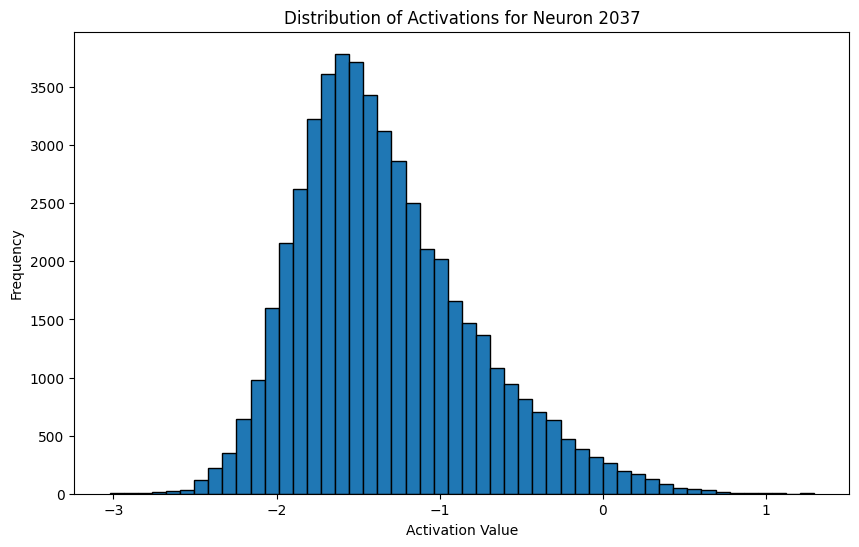

In [14]:
import matplotlib.pyplot as plt
target_neuron = 2037
activations = target_activations[:, target_neuron].tolist()

plt.figure(figsize=(10, 6))
plt.hist(activations, bins=50, edgecolor='black')
plt.title(f'Distribution of Activations for Neuron {target_neuron}')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.show()

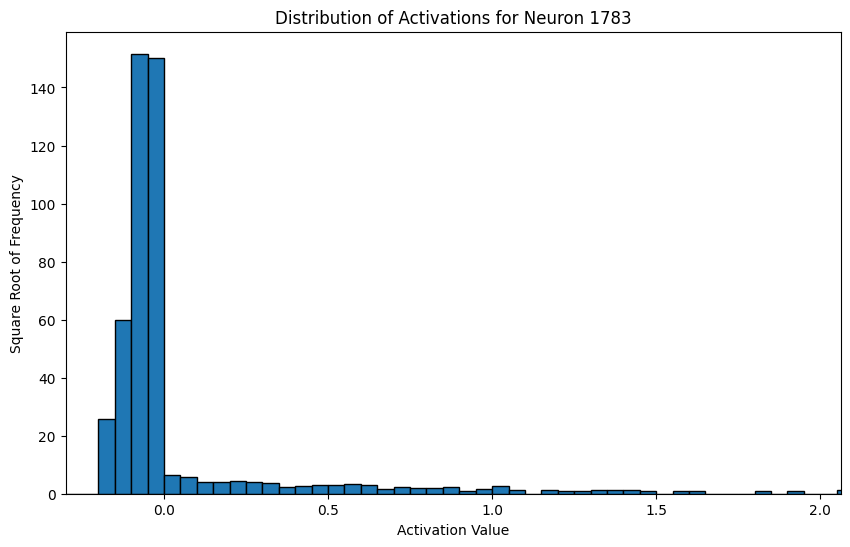

In [ ]:
target_neuron = 1783
activations = target_activations[:, target_neuron].tolist()

# Define the bins
bin_size = 0.05
bin_start = -0.3
bin_end = max(activations)
if bin_end<2:
    bin_end=2
bins = np.arange(bin_start, bin_end + bin_size, bin_size)

plt.figure(figsize=(10, 6))

# Create the histogram
counts, bins, _ = plt.hist(activations, bins=bins, edgecolor='black')

# Calculate the square root of the counts
sqrt_counts = np.sqrt(counts)

# Clear the current plot
plt.clf()

# Plot the histogram with square root of frequency
plt.bar(bins[:-1], sqrt_counts, width=np.diff(bins), edgecolor='black', align='edge')

plt.title(f'Distribution of Activations for Neuron {target_neuron}')
plt.xlabel('Activation Value')
plt.ylabel('Square Root of Frequency')

# Adjust y-axis to start from 0
plt.ylim(bottom=0)

# Adjust x-axis to show the full range
plt.xlim(bin_start, bin_end)

plt.show()

In [ ]:
neuron_mins = torch.min(target_activations, dim=0)[0].cpu()

In [ ]:
import numpy as np

# List of concept column names
concept_columns = [f'concept{i}' for i in range(10)]

# Calculate the number of non-empty entries for each concept column
non_empty_concepts = resnet50_4_part[concept_columns].astype(str).ne('0').sum()

# Display the results
display(non_empty_concepts)

# Display as a horizontal list
display(non_empty_concepts.values)

concept0    2048
concept1    2043
concept2    1992
concept3    1744
concept4    1178
concept5     472
concept6      96
concept7       3
concept8       1
concept9       0
dtype: int64

array([2048, 2043, 1992, 1744, 1178,  472,   96,    3,    1,    0],
      dtype=int64)

In [ ]:
# Find the row where concept6 is non-zero
row_with_seven_concepts = vitb16_11_mlp1[vitb16_11_mlp1['concept6'] != '0']

# Display the row
display(row_with_seven_concepts)

# If there's only one such row, we can also display it as a Series for better readability
if len(row_with_seven_concepts) == 1:
    display(row_with_seven_concepts.iloc[0])

,val correlation,sim correlation,weight0,concept0,weight1,concept1,weight2,concept2,weight3,concept3,...,concept5,weight6,concept6,weight7,concept7,weight8,concept8,weight9,concept9,bias
unit,,,,,,,,,,,,,,,,,,,,,
75,0.805458,0.734027,0.978286,triumphal arch,0.826798,rickshaw,0.801762,carrousel,0.74295,gondola,...,maypole,0.11965,carriage,0,0,0,0,0,0,-0.023549


val correlation          0.805458
sim correlation          0.734027
weight0                  0.978286
concept0           triumphal arch
weight1                  0.826798
concept1                 rickshaw
weight2                  0.801762
concept2                carrousel
weight3                   0.74295
concept3                  gondola
weight4                  0.721708
concept4             ford model t
weight5                  0.562891
concept5                  maypole
weight6                   0.11965
concept6                 carriage
weight7                         0
concept7                        0
weight8                         0
concept8                        0
weight9                         0
concept9                        0
bias                    -0.023549
Name: 75, dtype: object

In [ ]:
# List of columns to drop
columns_to_drop = ['weight7', 'concept7', 'weight8', 'concept8', 'weight9', 'concept9']

# # Drop the specified columns
# vitb16_11_mlp1 = vitb16_11_mlp1.drop(columns=columns_to_drop)
# vitl32_23_mlp1 =vitl32_23_mlp1.drop(columns=columns_to_drop)



In [ ]:
avg_val_correlation = vitb16_11_mlp1['val correlation'].mean()

# Calculate average sim correlation
avg_sim_correlation = vitb16_11_mlp1['sim correlation'].mean()

# Display the results
print(f"Average val correlation: {avg_val_correlation:.4f}")
print(f"Average sim correlation: {avg_sim_correlation:.4f}")

Average val correlation: 0.4045
Average sim correlation: 0.3489


In [ ]:
def format_row(row):
    concepts = []
    for i in range(7):  # We now have only 0-6 after dropping 7-9
        weight = row[f'weight{i}']
        concept = row[f'concept{i}']
        if concept != '0' and concept != 0 and not pd.isna(concept):
            if weight < 0:
                concepts.append(f"- {abs(weight):.6f} {concept}")
            else:
                concepts.append(f"+ {weight:.6f} {concept}")
    
    concept_string = ' '.join(concepts).strip('+ ')  # Remove leading '+ ' if present
    if row['bias'] != 0:
        if row['bias'] < 0:
            concept_string += f" - {abs(row['bias']):.6f}"
        else:
            concept_string += f" + {row['bias']:.6f}"
    
    return f"{row.name}, {concept_string}, {row['val correlation']:.6f}, {row['sim correlation']:.6f}"

# Create the formatted strings
formatted_rows = vitb16_11_mlp1_part.apply(format_row, axis=1)

# Write to file
with open('reproduced/vit_b_16_layer_11_mlp1_part.txt', 'w') as f:
    f.write("unit, weighted_concepts_and_bias, val_correlation, sim_correlation\n")
    for row in formatted_rows:
        f.write(row + '\n')

print("File 'reproduced/vit_b_16_layer_11_mlp1.txt' has been created.")

# Display the first few lines of the file to verify
with open('reproduced/vit_b_16_layer_11_mlp1_part.txt', 'r') as f:
    print("\nFirst few lines of the created file:")
    print(''.join(f.readlines()[:6]))

File 'reproduced/vit_b_16_layer_11_mlp1.txt' has been created.

First few lines of the created file:
unit, weighted_concepts_and_bias, val_correlation, sim_correlation
0, 3.244452 fishing casting reel + 0.747201 rod - 0.033834, 0.611978, 0.650084
1, 1.469008 Australian Terrier + 0.617166 Groenendael dog - 0.014949, 0.701853, 0.707056
2, 1.078844 Affenpinscher + 0.651773 Pekingese - 0.006152, 0.649824, 0.679919
3, 1.180777 truck + 0.678471 garbage truck - 0.007393, 0.722593, 0.568887
4, 0.879432 red admiral butterfly + 0.633619 ladybug - 0.008216, 0.809036, 0.585127



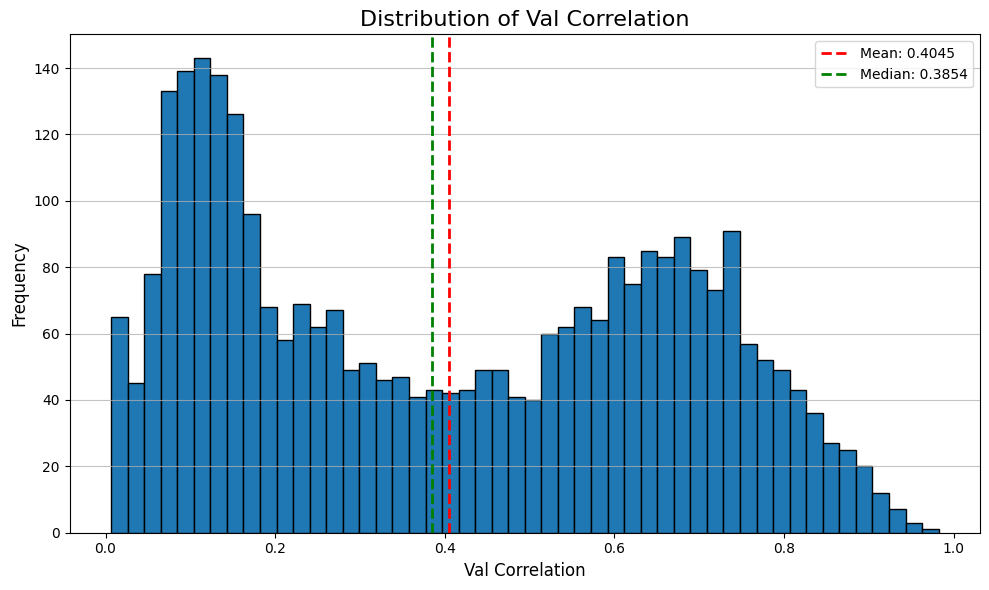

Mean val correlation: 0.4045
Median val correlation: 0.3854
Min val correlation: 0.0065
Max val correlation: 0.9823


In [ ]:
import matplotlib.pyplot as plt

# Assuming vitb16_11_mlp1 is already loaded

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(vitb16_11_mlp1['val correlation'], bins=50, edgecolor='black')

# Set title and labels
plt.title('Distribution of Val Correlation', fontsize=16)
plt.xlabel('Val Correlation', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add grid for better readability
plt.grid(axis='y', alpha=0.75)

# Calculate and display mean and median
mean_val = vitb16_11_mlp1['val correlation'].mean()
median_val = vitb16_11_mlp1['val correlation'].median()

plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.4f}')
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.4f}')

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

# Print additional statistics
print(f"Mean val correlation: {mean_val:.4f}")
print(f"Median val correlation: {median_val:.4f}")
print(f"Min val correlation: {vitb16_11_mlp1['val correlation'].min():.4f}")
print(f"Max val correlation: {vitb16_11_mlp1['val correlation'].max():.4f}")


In [ ]:

# Filter rows with val_correlation less than 0.01
low_val_corr = vitb16_11_mlp1[(vitb16_11_mlp1['val correlation'] > 0.2)&(vitb16_11_mlp1['weight0']<0.02)]

# Sort by val_correlation in ascending order
low_val_corr_sorted = low_val_corr.sort_values('val correlation')

# Display the results
print(f"Number of rows with val_correlation < 0.1: {len(low_val_corr)}")
display(low_val_corr_sorted)

# If there are many rows, you might want to display only the top few
if len(low_val_corr) > 10:
    print("\nShowing only the 10 lowest val_correlation rows:")
    display(low_val_corr_sorted.tail(20))

Number of rows with val_correlation < 0.1: 3


,val correlation,sim correlation,weight0,concept0,weight1,concept1,weight2,concept2,weight3,concept3,weight4,concept4,weight5,concept5,weight6,concept6,bias
unit,,,,,,,,,,,,,,,,,
1058,0.230455,0.236316,-0.030931,matted,-0.060297,leash,0.00000,0,0.0,0,0.0,0,0.0,0,0.0,0,-0.002798
253,0.261455,0.090732,-0.034127,goldfish,-0.058280,hammerhead shark,-0.08295,electric ray,0.0,0,0.0,0,0.0,0,0.0,0,-0.010733
940,0.271247,0.201404,-0.010043,electric ray,-0.024586,great white shark,0.00000,0,0.0,0,0.0,0,0.0,0,0.0,0,-0.000630


In [ ]:
concept_columns = [col for col in vitb16_10_mlp1.columns if col.startswith('concept')]

# Create a list of all concepts, excluding empty strings and '0'
all_concepts = []

for col in concept_columns:
    # Get non-empty and non-zero concepts from the column
    concepts = vitb16_10_mlp1_part[col].dropna().astype(str)
    concepts = concepts[concepts != '0']
    all_concepts.extend(concepts.tolist())

# Remove duplicates and sort
all_concepts = sorted(set(all_concepts))

# Display the first few concepts and the total count
print(f"Total unique concepts: {len(all_concepts)}")

Total unique concepts: 1385


In [ ]:
def save_list_to_file(lst, file_name):
    try:
        with open(file_name, 'w', encoding='utf-8') as file:
            for item in lst:
                file.write(f"{item}\n")
        print(f"List successfully saved to {file_name}")
    except Exception as e:
        print(f"An error occurred while saving the list: {e}")

def read_list_from_file(file_name):
    try:
        with open(file_name, 'r', encoding='utf-8') as file:
            lst = [line.strip() for line in file]
        print(f"List successfully read from {file_name}")
        return lst
    except FileNotFoundError:
        print(f"File not found: {file_name}")
        return []
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return []

save_list_to_file(all_concepts, 'vitb16_10_siglip_concepts.txt')

# Read the list from the file
all_concepts = read_list_from_file('vitb16_10_siglip_concepts.txt')

List successfully saved to vitb16_10_siglip_concepts.txt
List successfully read from vitb16_10_siglip_concepts.txt


In [ ]:
import json

# Read the JSON file
with open('categorize_concepts.json', 'r') as file:
    concepts_dict = json.load(file)

# Print the dictionary to verify
print(concepts_dict)

{'organism': ['Affenpinscher', 'Afghan Hound', 'African bush elephant', 'African rock python', 'African wild dog', 'Airedale Terrier', 'Alaskan Malamute', 'Alaskan tundra wolf', 'Alpine ibex', 'American Staffordshire Terrier', 'American alligator', 'American black bear', 'American bullfrog', 'American coot', 'American dipper', 'American lobster', 'American robin', 'Angora rabbit', 'Appenzeller Sennenhund', 'Arctic fox', 'Asian elephant', 'Australian Kelpie', 'Australian Silky Terrier', 'Australian Terrier', 'Basenji', 'Basset Hound', 'Beagle', 'Bedlington Terrier', 'Bernese Mountain Dog', 'Black and Tan Coonhound', 'Bloodhound', 'Bluetick Coonhound', 'Border Collie', 'Border Terrier', 'Boston Terrier', 'Bouvier des Flandres dog', 'Boxer', 'Briard', 'Brittany dog', 'Bullmastiff', 'Cairn Terrier', 'Cardigan Welsh Corgi', 'Carolina anole', 'Chesapeake Bay Retriever', 'Chihuahua', 'Chow Chow', 'Clumber Spaniel', 'Cocker Spaniel', 'Curly-coated Retriever', 'Dalmatian', 'Dandie Dinmont Terri

In [ ]:
def create_concept_category_dataframe(concept_list, concept_dict):
    # Initialize a list to store category for each concept
    categories = []
    
    for concept in concept_list:
        # Find the category for the concept
        category = next((cat for cat, concepts in concept_dict.items() if concept in concepts), None)
        categories.append(category)
    
    # Create the DataFrame
    df = pd.DataFrame({
        'Concept': concept_list,
        'Category': categories
    })
    
    return df

concepts_df = create_concept_category_dataframe(all_concepts, concepts_dict)

In [ ]:
target_model=vitb16_10_mlp1_part
def categorize_neuron(row, concepts_df):
    category_weights = {}
    total_weight = 0
    
    for i in range(7):  # We now have concepts 0-6
        concept = row[f'concept{i}']
        weight = row[f'weight{i}']
        if concept=="0":
            break
        try:
            category = concepts_df.loc[concepts_df['Concept'] == concept, 'Category'].iloc[0]
            category_weights[category] = category_weights.get(category, 0) + weight
            total_weight += weight
        except:
            print(f"error, concept [{concept}] not found in df")
    
    if total_weight > 0:
        max_category = max(category_weights, key=category_weights.get)
        max_category_weight = category_weights[max_category] / total_weight
    else:
        max_category = 'Unknown'
        max_category_weight = 0
    
    return pd.Series({'category': max_category, 'category_weight': max_category_weight})

# Apply the function to each row
result = target_model.apply(categorize_neuron, axis=1, args=(concepts_df,))

# Add the new columns to the DataFrame
target_model[['category', 'category_weight']] = result

# Display the first few rows to verify
display(target_model.head())

# Display category distribution
display(target_model['category'].value_counts(normalize=True))

C:\Users\15566\AppData\Local\Temp\ipykernel_15992\1848911718.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_model[['category', 'category_weight']] = result
C:\Users\15566\AppData\Local\Temp\ipykernel_15992\1848911718.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_model[['category', 'category_weight']] = result


,val correlation,sim correlation,weight0,concept0,weight1,concept1,weight2,concept2,weight3,concept3,...,concept6,weight7,concept7,weight8,concept8,weight9,concept9,bias,category,category_weight
unit,,,,,,,,,,,,,,,,,,,,,
0,0.257394,0.234598,0.036944,aquatic bird,0.034737,canine,0.000000,0,0.000000,0,...,0,0,0,0,0,0,0,-0.054195,organism,1.000000
1,0.197930,0.258940,0.116511,whale,0.101620,sea,0.000000,0,0.000000,0,...,0,0,0,0,0,0,0,-0.082422,organism,0.534133
2,0.326336,0.293699,0.056167,wildlife,0.038332,aquatic bird,0.036621,canine,0.000000,0,...,0,0,0,0,0,0,0,-0.051107,organism,1.000000
3,0.492312,0.434086,0.074501,waterfowl,0.070542,bird,0.048509,leptocephalus,0.045754,canine,...,0,0,0,0,0,0,0,-0.104975,organism,1.000000
4,0.162585,0.155064,0.120482,evening-wear,0.069030,"doorway, indoor",0.000000,0,0.000000,0,...,0,0,0,0,0,0,0,-0.098202,objects,0.635749


category
objects              0.403126
organism             0.321068
places/scenes        0.147183
abstract concepts    0.100619
people               0.016607
texture/patterns     0.011397
Name: proportion, dtype: float64

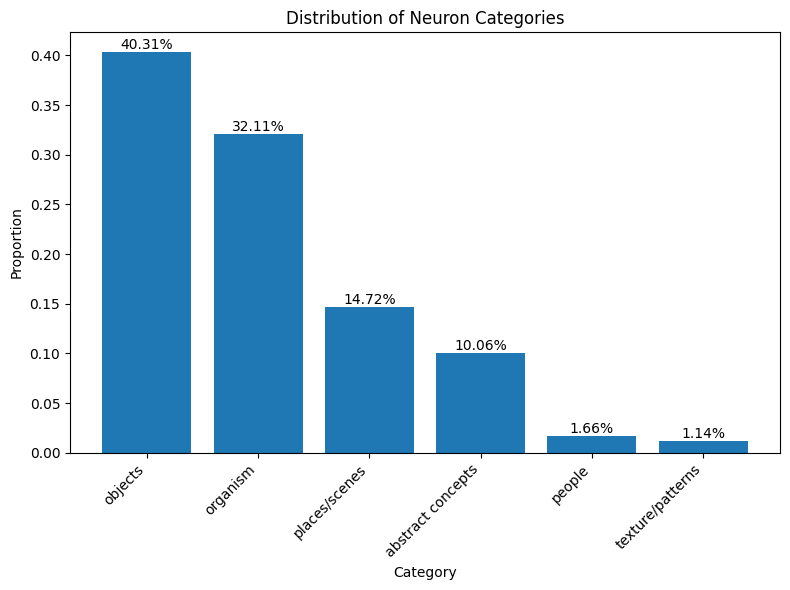

In [ ]:
import matplotlib.pyplot as plt

# Calculate the category distribution
category_distribution = target_model['category'].value_counts(normalize=True)

# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(category_distribution.index, category_distribution.values)

# Customize the plot
plt.title('Distribution of Neuron Categories')
plt.xlabel('Category')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}',
             ha='center', va='bottom')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Display the plot
plt.show()

## cbm

In [49]:
import pandas as pd
HOME="/home/jix049/private/"
target="cifar10_cbm_manual_concepts_acc2"#"imagenet","cub"

# Read LE
# df = pd.read_csv(Home+f'results/le_siglip_{target}_proj_layer.csv')
# Convert the 'layer' column to string type to preserve leading zeros
# df['layer'] = df['layer'].astype(str)

# Remove the 'layer' column and set 'unit' as the index
# cbm = df.drop(columns=['layer']).set_index('unit')
# cbm = df.drop(columns=['layer','weight8','weight7','weight9','concept7','concept8','concept9']).set_index('unit')



In [50]:
def read_concepts_from_file(filename):
    concepts = []
    with open(filename, 'r') as file:
        for line in file:
            # Strip whitespace and add non-empty lines to the list
            concept = line.strip()
            if concept:
                concepts.append(concept)
    return concepts

# Example usage
filename = f"/home/jix049/private/saved_models/{target}/concepts.txt"
concept_list = read_concepts_from_file(filename)

In [51]:
# Input file name
# input_csv = HOME+'CLIP-dissect/'+f'results/{target}_24_10_23_18_35/descriptions.csv'
input_csv = HOME+'CLIP-dissect/'+f'results/{target}_24_10_23_21_18/descriptions.csv'

# Read CSV file
df = pd.read_csv(input_csv)

# Assuming you already have a DataFrame named 'cbm'
# If you don't, you can create a dummy one for testing purposes:
# cbm = pd.DataFrame(index=range(5))  # Create a dummy DataFrame with 5 rows

# Set 'unit' as the index of the input DataFrame
df.set_index('unit', inplace=True)

# Add 'description' and 'similarity' columns to 'cbm'
# cbm['clip_dissect'] = df['description']
# cbm['cd_similarity'] = df['similarity']
cbm=df

# Print the updated 'cbm' DataFrame to verify the changes
display(cbm)

,layer,description,similarity
unit,,,
0,proj_layer,a barn,2.770874
1,proj_layer,a beak,4.116577
2,proj_layer,truck,4.139526
3,proj_layer,a birdfeeder,4.340851
4,proj_layer,large sails,4.401092
...,...,...,...
92,proj_layer,machine,0.370239
93,proj_layer,whiskers,4.228027
94,proj_layer,white spots on the coat,3.255158


In [52]:
cbm['true_concept'] = concept_list
# Now, reorder the columns to make 'true_concept' the first column
columns = ['true_concept'] + [col for col in cbm.columns if col != 'true_concept']
cbm = cbm[columns]

In [53]:
cbm.head()

,true_concept,layer,description,similarity
unit,,,,
0,a barn,proj_layer,a barn,2.770874
1,a beak,proj_layer,a beak,4.116577
2,a cargo bed,proj_layer,truck,4.139526
3,a birdfeeder,proj_layer,a birdfeeder,4.340851
4,a boat,proj_layer,large sails,4.401092


In [54]:
import torch
import open_clip
from scipy.spatial.distance import cosine

# Load the CLIP model and tokenizer
model_name = "ViT-L-14"
pretrained = "openai"
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer = open_clip.get_tokenizer(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

def get_text_features(text, model, tokenizer):
    with torch.no_grad():
        text_tokens = tokenizer(text).to(device)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features.cpu().numpy()

def compute_similarity(concept1, concept2):
    # Get text features for both concepts
    features1 = get_text_features(concept1, model, tokenizer)
    features2 = get_text_features(concept2, model, tokenizer)
    
    # Compute cosine similarity
    similarity = 1 - cosine(features1[0], features2[0])
    return similarity

# Example usage
concept1 = "a red apple"
concept2 = "a green apple"

similarity_score = compute_similarity(concept1, concept2)
print(f"Cosine similarity between '{concept1}' and '{concept2}': {similarity_score}")

Cosine similarity between 'a red apple' and 'a green apple': 0.8231900825017755


In [36]:
# Example usage
concept1 = "Indigo Bunting"
concept2 = "hound"

similarity_score = compute_similarity(concept1, concept2)
print(f"Cosine similarity between '{concept1}' and '{concept2}': {similarity_score}")

Cosine similarity between 'Indigo Bunting' and 'hound': 0.3729809820652008


In [55]:
def compute_row_similarity(row):
    return compute_similarity(row['true_concept'], row['description'])

# Add 'true_similarity' column to the DataFrame
cbm['true_similarity'] = cbm.apply(compute_row_similarity, axis=1)

/tmp/ipykernel_320/746729890.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbm['true_similarity'] = cbm.apply(compute_row_similarity, axis=1)


In [40]:
# cbm_acc.head()

,true_concept,layer,description,similarity,true_similarity
unit,,,,,
0,a barn,proj_layer,a barn,3.050507,1.000000
1,a beak,proj_layer,a long neck,2.883514,0.763582
2,a cargo bed,proj_layer,a toy,1.478638,0.700346
3,a birdfeeder,proj_layer,a birdfeeder,3.472290,1.000000
4,a boat,proj_layer,multiple sails,3.512817,0.737358


In [56]:
cbm["true_similarity"].mean()

0.8303804632346632

In [58]:
# Assuming cbm is a pandas DataFrame
count = (cbm["true_similarity"] == 1).sum()

print(f"Number of rows where true_similarity is 1: {count}")

Number of rows where true_similarity is 1: 35


In [42]:
# x is cbm, y is cbm with acc
merged_df = cbm.merge(cbm_acc, on='true_concept', how='outer')

In [47]:
merged_df[:50]

,true_concept,description_x,similarity_x,true_similarity_x,description_y,similarity_y,true_similarity_y
0,a barn,a barn,1.821716,1.000000,a barn,3.050507,1.000000
1,a beak,a cage,0.278015,0.742303,a long neck,2.883514,0.763582
2,a bed,machine,0.290283,0.760321,NaN,NaN,NaN
3,a birdfeeder,a birdfeeder,4.573608,1.000000,a birdfeeder,3.472290,1.000000
4,a boat,ship,4.524506,0.870423,multiple sails,3.512817,0.737358
5,a branch,a branch,1.693451,1.000000,webbed feet,2.619385,0.640602
6,a bridle,horse,4.000977,0.788635,horse,2.980347,0.788635
7,a brown body,a brown body,0.829651,1.000000,food,1.360535,0.715157
8,a cab for the driver,a cab for the driver,4.473938,1.000000,four wheels,2.511078,0.786231
9,a cage,machine,0.535950,0.776874,a cage,1.286713,1.000000


In [48]:
merged_df[50:]

,true_concept,description_x,similarity_x,true_similarity_x,description_y,similarity_y,true_similarity_y
50,a road,a trailer,4.148041,0.774622,a cargo bed,2.637878,0.691093
51,a rudder,"a large, metal body",1.421539,0.590923,large sails,2.751831,0.662604
52,a runway,a runway,4.553375,1.000000,a runway,4.227142,1.000000
53,a saddle,a brown body,1.803833,0.648122,a saddle,2.696014,1.000000
54,a scratching post,cat,4.462006,0.715732,cat,4.181335,0.715732
55,a seat,NaN,NaN,NaN,a windshield,1.308746,0.687529
56,a slender body,a leash,1.431732,0.666614,webbed feet,2.479675,0.659599
57,"a small, lithe body",a brown body,1.846100,0.743313,a litter box,2.342163,0.720301
58,a steering wheel,four wheels,3.199768,0.776736,a dashboard,2.233490,0.774499
59,a tail,a tail,3.237976,1.000000,a tail,1.869843,1.000000


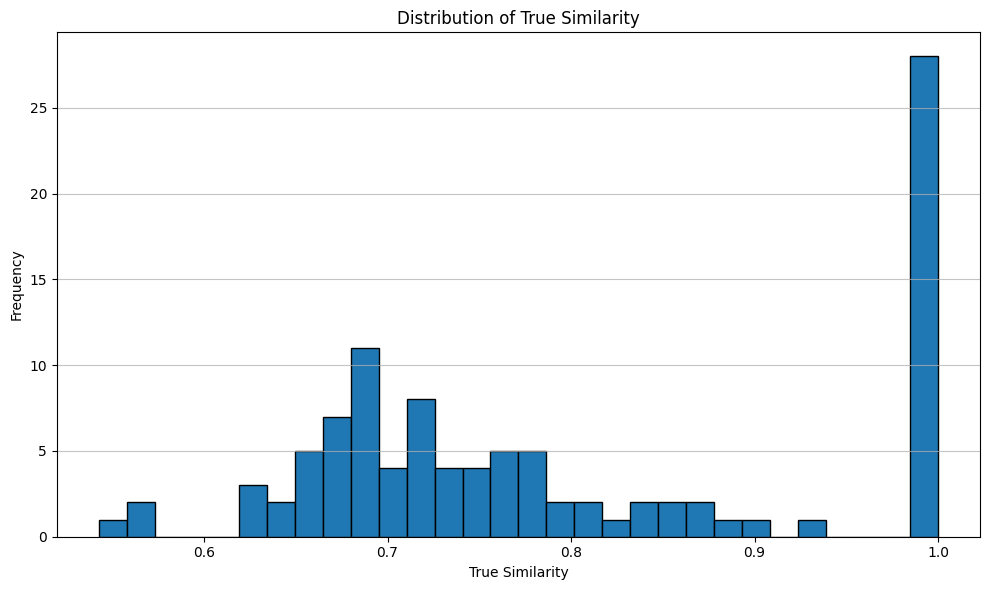

In [25]:
import matplotlib.pyplot as plt

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(cbm['true_similarity'], bins=30, edgecolor='black')

# Add labels and title
plt.xlabel('True Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of True Similarity')

# Add grid for better readability
plt.grid(axis='y', alpha=0.75)

# Display the plot
plt.tight_layout()
plt.show()

In [13]:
def compute_top_5_similarity(row):
    n=5
    best_sim=0
    total_sim=0
    total_concepts=0
    for i in range(n):
        if row[f"weight{i}"]==0:
            break
        sim=compute_similarity(row['true_concept'],row[f"concept{i}"])
        total_sim+=sim
        total_concepts+=1
        if sim>best_sim:
            best_sim=sim
    return pd.Series({'top_5_similarity': best_sim, 'avg_5_similarity': total_sim/total_concepts})
cbm[["top_5_similarity","avg_5_similarity"]]=cbm.apply(compute_top_5_similarity, axis=1)

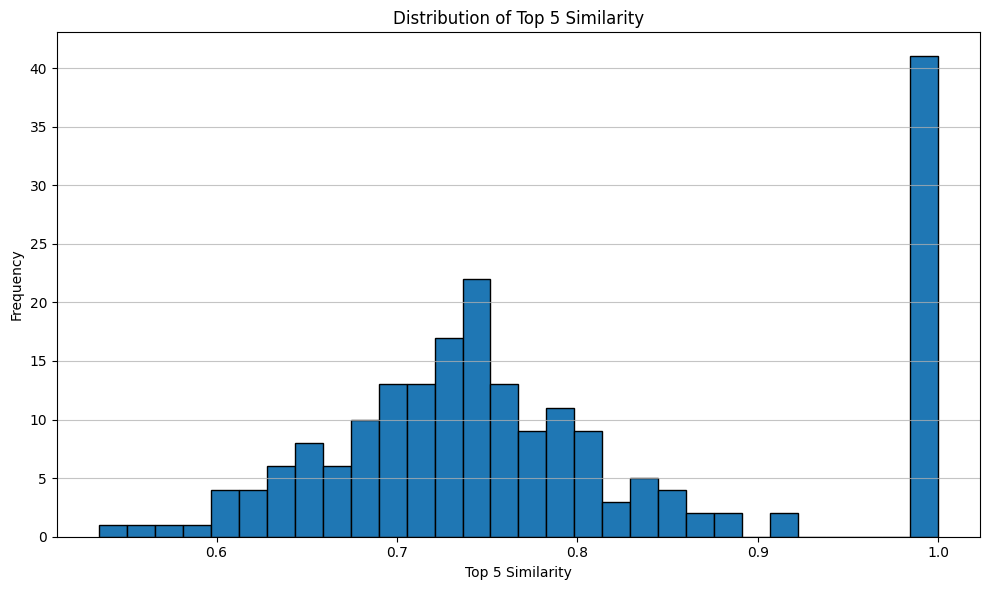

In [14]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(cbm['top_5_similarity'], bins=30, edgecolor='black')

# Add labels and title
plt.xlabel('Top 5 Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Top 5 Similarity')

# Add grid for better readability
plt.grid(axis='y', alpha=0.75)

# Display the plot
plt.tight_layout()
plt.show()

In [15]:
cbm["top_5_similarity"].mean()

0.784976259834485

In [16]:
# Assuming cbm is a pandas DataFrame
count = (cbm["top_5_similarity"] == 1).sum()

print(f"Number of rows where true_similarity is 1: {count}")

Number of rows where true_similarity is 1: 41


In [17]:
cbm["avg_5_similarity"].mean()

0.6692230940969607

In [25]:
cbm[]

,true_concept,val correlation,weight0,concept0,weight1,concept1,weight2,concept2,weight3,concept3,...,weight8,concept8,weight9,concept9,bias,clip_dissect,cd_similarity,true_similarity,top_5_similarity,avg_5_similarity
unit,,,,,,,,,,,,,,,,,,,,,
10,a black back,0.693104,1.114747,large black bird,0.734271,"a dark, glossy bill",0.0,0,0.0,0,...,0,0,0,0,-0.500986,a black patch on the back,2.680756,0.856555,0.709187,0.700082


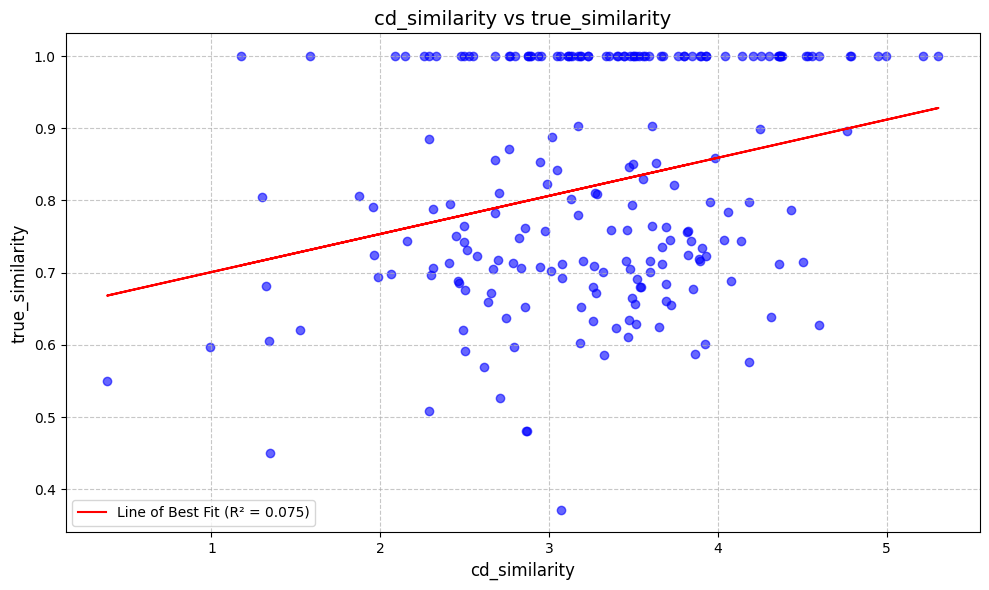

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

x="cd_similarity"
y="true_similarity"
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(cbm[x], cbm[y], alpha=0.6, color='blue')

# Calculate the line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(cbm[x], cbm[y])
line = slope * cbm[x] + intercept

# Add the line of best fit
plt.plot(cbm[x], line, color='red', label=f'Line of Best Fit (R² = {r_value**2:.3f})')

# Set labels and title
plt.xlabel(x, fontsize=12)
plt.ylabel(y, fontsize=12)
plt.title(x+' vs '+y, fontsize=14)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend()

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

In [24]:
import os
import numpy as np
os.environ["OMP_NUM_THREADS"] = "1"
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def try_two_cluster(concepts):
    # Get embeddings for all concepts
    embeddings = np.array([get_text_features(concept, model, tokenizer)[0] for concept in concepts])
    
    # Normalize embeddings
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    kmeans = KMeans(n_clusters=2, random_state=42).fit(embeddings)
    silhouette = silhouette_score(embeddings, kmeans.labels_)
    
    # Compare silhouette scores to determine the optimal number of clusters
    if silhouette > 0.15:
        return 2, kmeans.labels_ # Two clusters
    else:
        return 1, [0]*len(concepts)  # One cluster

# Example usage
concepts_lists = [
    ["dog", "cat", "fish", "car", "truck", "boat"],
    ["parrot","bird of prey","bird"],
    ["hound","ski","snow mobile","sled","ski mask","canine"],
    ["happiness", "joy", "elation", "delight"]
]

for i, concepts in enumerate(concepts_lists):
    _, clusters = try_two_cluster(concepts)
    print(f"\nConcept list {i+1}:")
    for concept, cluster in zip(concepts, clusters):
        print(f"{concept}: Cluster {cluster}")

c:\Users\15566\anaconda3\envs\le\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\15566\anaconda3\envs\le\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\15566\anaconda3\envs\le\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\15566\anaconda3\envs\le\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known


Concept list 1:
dog: Cluster 0
cat: Cluster 0
fish: Cluster 0
car: Cluster 0
truck: Cluster 0
boat: Cluster 0

Concept list 2:
parrot: Cluster 0
bird of prey: Cluster 0
bird: Cluster 0

Concept list 3:
hound: Cluster 1
ski: Cluster 0
snow mobile: Cluster 0
sled: Cluster 0
ski mask: Cluster 0
canine: Cluster 1

Concept list 4:
happiness: Cluster 1
joy: Cluster 0
elation: Cluster 1
delight: Cluster 1


In [25]:
def is_polysemantic(row):
    num_concepts=1+int(row["weight1"]>0)+int(row["weight2"]>0)+int(row["weight3"]>0)+int(row["weight4"]>0)+int(row["weight5"]>0)+int(row["weight6"]>0)
    if num_concepts==1:
        return False
    if num_concepts==2:
        if compute_similarity(row["concept0"],row["concept1"])>0.6:
            return False
        else:
            return True
    concepts_list=[]
    for i in range(num_concepts):
        concepts_list.append(row[f"concept{i}"])
    result,detail=try_two_cluster(concepts_list)
    return result==2
cbm["polysemantic"]=cbm.apply(is_polysemantic,axis=1)

c:\Users\15566\anaconda3\envs\le\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\15566\anaconda3\envs\le\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\15566\anaconda3\envs\le\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\15566\anaconda3\envs\le\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known

In [34]:
n=7
cbm[cbm["polysemantic"]].index[20*(n-1):20*n]

Index([2114, 2158, 2160, 2161, 2195, 2196, 2234, 2252, 2262, 2268, 2287, 2311,
       2320, 2346, 2348, 2403, 2438, 2476, 2491, 2509],
      dtype='int64', name='unit')

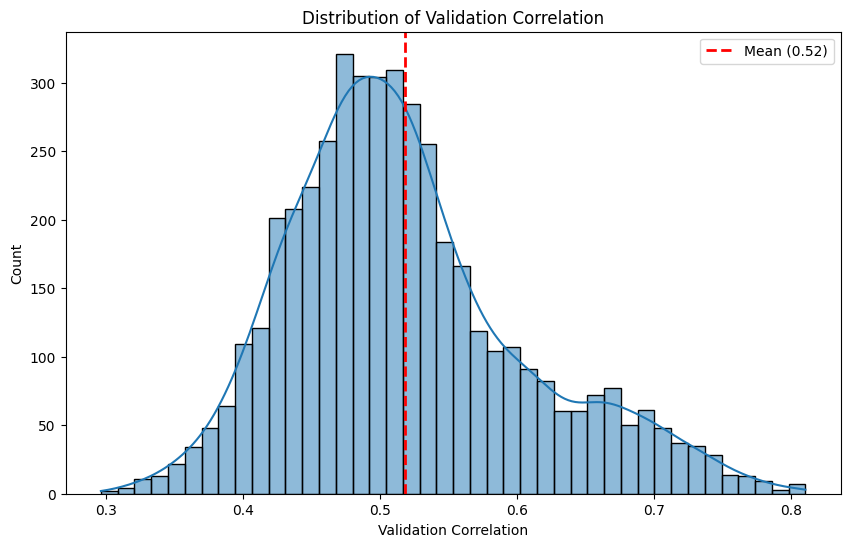

Mean validation correlation: 0.5181


In [ ]:


# Assuming cbm_cifar100 is your DataFrame

# Calculate the mean of 'val correlation'
mean_correlation = cbm['val correlation'].mean()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the distribution
sns.histplot(data=cbm, x='val correlation', kde=True)

# Add a vertical line for the mean
plt.axvline(mean_correlation, color='r', linestyle='dashed', linewidth=2, label=f'Mean ({mean_correlation:.2f})')

# Customize the plot
plt.title('Distribution of Validation Correlation')
plt.xlabel('Validation Correlation')
plt.ylabel('Count')
plt.legend()

# Show the plot
plt.show()

# Print the mean for reference
print(f"Mean validation correlation: {mean_correlation:.4f}")

In [ ]:
len(cbm)

4523

In [ ]:
single_concept_rows = cbm[
    (cbm['concept1'] == '0')
]


In [ ]:
single_concept_rows

,true_concept,val correlation,weight0,concept0,weight1,concept1,weight2,concept2,weight3,concept3,...,concept5,weight6,concept6,weight7,concept7,weight8,concept8,weight9,concept9,bias
unit,,,,,,,,,,,,,,,,,,,,,
115,a band,0.404393,2.776201,instrument,0.0,0,0.0,0,0.0,0,...,0,0.0,0,0.0,0,0,0,0,0,-1.582166
174,a bird book,0.635727,4.189422,other birds,0.0,0,0.0,0,0.0,0,...,0,0.0,0,0.0,0,0,0,0,0,-1.467975
538,a copilot,0.505000,3.530838,dog,0.0,0,0.0,0,0.0,0,...,0,0.0,0,0.0,0,0,0,0,0,-0.455693
803,a fire pit,0.320995,12.566013,a fire pit,0.0,0,0.0,0,0.0,0,...,0,0.0,0,0.0,0,0,0,0,0,-1.173499
1617,a pack,0.571590,3.937324,dogs,0.0,0,0.0,0,0.0,0,...,0,0.0,0,0.0,0,0,0,0,0,-0.766531
1762,a plane,0.363545,5.567991,able to fly long distances,0.0,0,0.0,0,0.0,0,...,0,0.0,0,0.0,0,0,0,0,0,-1.235347
2219,a small to medium-sized bird,0.712191,4.841223,other birds,0.0,0,0.0,0,0.0,0,...,0,0.0,0,0.0,0,0,0,0,0,-1.618851
2536,"a tall, pink bird",0.585869,3.708490,other birds,0.0,0,0.0,0,0.0,0,...,0,0.0,0,0.0,0,0,0,0,0,-1.470430
2657,a train,0.402929,4.725114,often has a train,0.0,0,0.0,0,0.0,0,...,0,0.0,0,0.0,0,0,0,0,0,-1.213290


In [ ]:
# Find rows where 'fins' is part of the 'true_concept'
fins_rows = cbm[cbm['true_concept'].str.contains('fins', case=False, na=False)]

# Display these rows
display(fins_rows.drop(columns=columns_to_drop))

,true_concept,val correlation,weight0,concept0,weight1,concept1,weight2,concept2,weight3,concept3,weight4,concept4,weight5,concept5,weight6,concept6,bias
unit,,,,,,,,,,,,,,,,,
801,a fins or wings at the back,0.607722,4.265757,jet,2.884650,"long, flowing fins",2.026925,other birds,1.988056,teeming with marine life,1.692488,white markings on the wings,0.0,0,0.0,0,-0.932963
2063,a series of metal fins,0.438008,5.373683,a plastic or metal material,4.134853,"a slender, vertical support",3.079486,keys along the side,2.610630,utensil,2.345513,usually has a boat-like hull,0.0,0,0.0,0,-1.248378
3357,fins,0.412956,10.023704,fins,3.117969,strap,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.0,0,-0.811282
3358,fins on its back and tail,0.655691,3.683829,"long, flowing fins",2.235987,in water,2.076554,leptocephalus,1.798897,"a long, tapered tail",1.628396,invertebrate,0.0,0,0.0,0,-1.180574
3561,large fins,0.596578,2.719322,other fish,2.399295,no dorsal fin,1.825708,usually found in shallow water,1.823853,usually has a boat-like hull,0.000000,0,0.0,0,0.0,0,-1.393257
3588,"large, triangular fins",0.662594,4.875241,vibrissae,3.359280,teeming with marine life,2.489433,"long, flowing fins",2.340224,reptile,2.098806,white markings on the wings,0.0,0,0.0,0,-1.430167
3640,"long, flowing fins",0.608032,3.626244,scenery,3.162326,"long, flowing fins",2.493683,no dorsal fin,1.621418,"a long, sharp bill",1.347401,"a long, snake-like shape",0.0,0,0.0,0,-1.087265
3820,orange fins,0.472915,5.073516,orange fins,2.516597,a yellow or orange body,2.238968,in water,0.000000,0,0.000000,0,0.0,0,0.0,0,-1.107236
3854,paddle-like fins,0.539261,8.781804,fins,4.848989,a flat sole,4.328575,able to float on water,1.648151,aquatic bird,0.000000,0,0.0,0,0.0,0,-1.406960
